In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, diff, cos, sin, sqrt, lambdify, simplify, Q, refine, nsolve, solve, pi
import rebound
rebound.__build__

'Aug  7 2023 15:46:31'

In [2]:
x,y, tau = symbols('x y tau', real=True)
e, E, epsilon = symbols('e E epsilon', positive=True)
dEdt = 1/(1-e*cos(E))        # Solar System Dynamics Eq. 2.50

In [145]:
dxs = [cos(E)-e]             # Solar System Dynamics Eq. 2.41
dys = [sqrt(1-e*e)*sin(E)]
dxs_apo = []
dys_apo = []
for i in range(9):
    dxs.append(diff(dxs[-1],E) * dEdt)
    dys.append(diff(dys[-1],E) * dEdt)    
for i in range(len(dxs)):
    dxs_apo.append( dxs[i].subs(E, pi) )
    dys_apo.append( dys[i].subs(E, pi) )
    dxs[i] = dxs[i].subs(E, 0)
    dys[i] = dys[i].subs(E, 0)
dxs = lambdify(e,dxs)
dys = lambdify(e,dys)
dxs_apo = lambdify(e,dxs_apo)
dys_apo = lambdify(e,dys_apo)

In [143]:
dxs_apo[4]

(e/(e + 1)**3 + (3*e/(e + 1)**2 - 1/(e + 1))/(e + 1))/(e + 1)**2

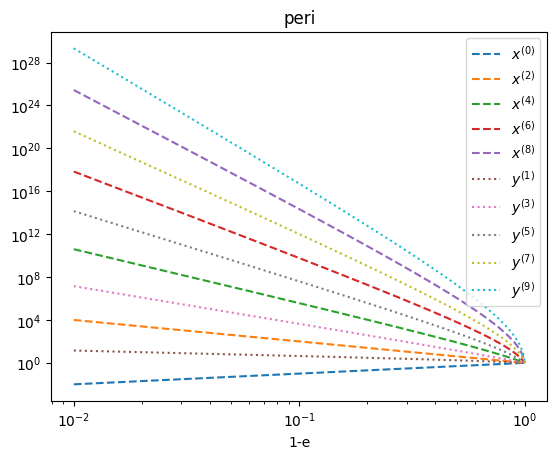

In [146]:
fig, ax = plt.subplots(1,1)
ax.set_title("peri")
ax.set_xlabel("1-e")
ax.set_xscale("log")
ax.set_yscale("log")
oneminuses = np.logspace(-2,-0.00001,1000)
_dxs = dxs(1.-oneminuses)
_dys = dys(1.-oneminuses)
for i in range(0,10,2):
    ax.plot(oneminuses, np.abs(_dxs[i]), ls="--", label="$x^{(%d)}$"%i)
for i in range(1,10,2):
    ax.plot(oneminuses, np.abs(_dys[i]), ls=":", label="$y^{(%d)}$"%i)
ax.legend();

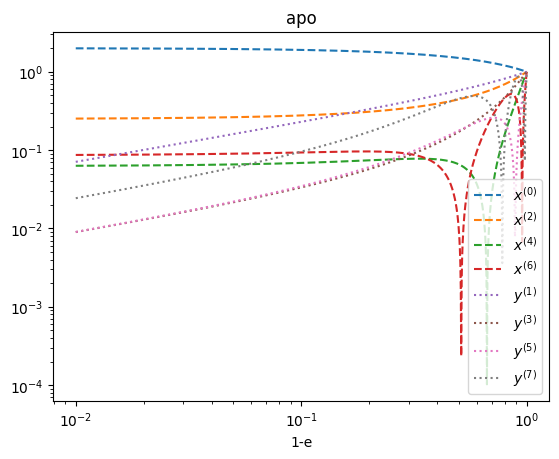

In [230]:
fig, ax = plt.subplots(1,1)
ax.set_title("apo")
ax.set_xlabel("1-e")
ax.set_xscale("log")
ax.set_yscale("log")
oneminuses = np.logspace(-2,-0.00001,1000)
_dxs = dxs_apo(1.-oneminuses)
_dys = dys_apo(1.-oneminuses)
for i in range(0,8,2):
    ax.plot(oneminuses, np.abs(_dxs[i]), ls="--", label="$x^{(%d)}$"%i)
for i in range(1,8,2):
    ax.plot(oneminuses, np.abs(_dys[i]), ls=":", label="$y^{(%d)}$"%i)
ax.legend();

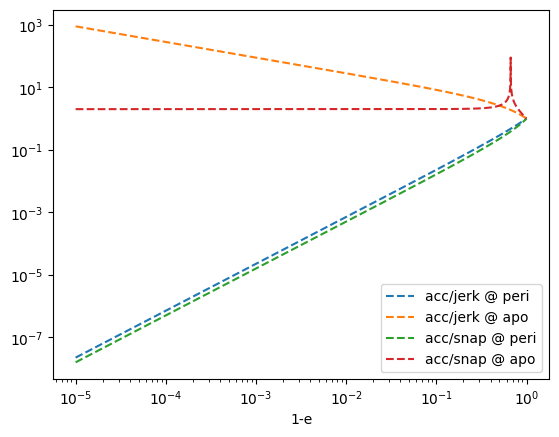

In [234]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("1-e")
ax.set_xscale("log")
ax.set_yscale("log")
oneminuses = np.logspace(-5,-0.00001,10000)
_dxs_apo = dxs_apo(1.-oneminuses)
_dys_apo = dys_apo(1.-oneminuses)
_dxs = dxs(1.-oneminuses)
_dys = dys(1.-oneminuses)

ax.plot(oneminuses, np.abs(_dxs[2]/_dys[3]), ls="--", label="acc/jerk @ peri")
ax.plot(oneminuses, np.abs(_dxs_apo[2]/_dys_apo[3]), ls="--", label="acc/jerk @ apo")
ax.plot(oneminuses, np.sqrt(np.abs(_dxs[2]/_dxs[4])), ls="--", label="acc/snap @ peri")
ax.plot(oneminuses, np.sqrt(np.abs(_dxs_apo[2]/_dxs_apo[4])), ls="--", label="acc/snap @ apo")
ax.legend();

In [5]:
dxs = [cos(E)-e]             # Solar System Dynamics Eq. 2.41
dys = [sqrt(1-e*e)*sin(E)]
for i in range(4):
    dxs.append(diff(dxs[-1],E) * dEdt)
    dys.append(diff(dys[-1],E) * dEdt)    
acc = sqrt(dxs[2]**2+dys[2]**2)
jerk = sqrt(dxs[3]**2+dys[3]**2)
timescale = acc/jerk
anal_dt = timescale*epsilon


In [6]:
jerk.subs(e,0.0).subs(E,0.)

1

In [7]:
anal_dt = simplify(anal_dt)
anal_dt

epsilon/(sqrt(((1 - e**2)*(-2*e*sin(E)**2 - e + cos(E))**2 + (3*e**2 - 2*e*cos(E) - 1)**2*sin(E)**2)/(e*cos(E) - 1)**10)*(e*cos(E) - 1)**2)

In [8]:
anal_dt_f = lambdify((e,E,epsilon),anal_dt)

In [39]:
d_anal_dt = diff(anal_dt,E)*dEdt
d_anal_dt_f = lambdify((e,E,epsilon), d_anal_dt)
dd_anal_dt = diff(d_anal_dt,E)*dEdt
dd_anal_dt_f = lambdify((e,E,epsilon), dd_anal_dt)

In [9]:
dxs = [cos(E)-e]             # Solar System Dynamics Eq. 2.41
dys = [sqrt(1-e*e)*sin(E)]
for i in range(9):
    dxs.append(diff(dxs[-1],E) * dEdt)
    dys.append(diff(dys[-1],E) * dEdt)    
a = lambdify((e,E),sqrt(dxs[2]**2+dys[2]**2))
j = lambdify((e,E),sqrt(dxs[3]**2+dys[3]**2))

In [222]:
_epsilon = 3.3*np.power(1e-9,1./7.)
print(_epsilon)
_safety = 0.85
_e = 0.99

_dtaus = []
_dtau = 0.2
_tau = np.pi
_failed = []
_Es = []
fail = 0

while _tau<5.0*np.pi:
    # try new timestep
    _E = nsolve((E-e*sin(E)-(_tau+_dtau)).subs(e,_e),_E,prec=10)
    _ndtau = anal_dt_f(_e, float(_E), _epsilon)
    if _ndtau > _dtau/_safety:
        _ndtau = _dtau/_safety
        fail = _ndtau
    if _ndtau < _dtau * _safety:
        fail = _ndtau
        pass
        
    else:
        _tau += _dtau
        _dtaus.append(_dtau)
        _Es.append(float(_E))
        _failed.append(fail)
        fail = np.nan
    _dtau = _ndtau


0.17092266441463


In [223]:
jerk_f = lambdify((e,E),jerk)
acc_f = lambdify((e,E),acc)

In [224]:
mindt = np.zeros(100000)
mindt[:] = np.nan
count = 0
dt_last_done = 0. 
def hb(simp):
    global mindt
    global count, dt_last_done
    if dt_last_done != simp.contents.dt_last_done:        
        mindt[count] = simp.contents.dt_last_done
        count +=1 
    dt_last_done = simp.contents.dt_last_done
    
sim = rebound.Simulation()
sim.ri_ias15.dt_mode = 1
sim.ri_ias15.epsilon_global = 0
sim.add(m=1)
sim.add(a=1,e=_e,f=np.pi)
sim.dt=0.2
sim.heartbeat = hb
sim.integrate(np.pi*4.,exact_finish_time=0)

In [225]:
d_dts = []
dts = []
for i in range(len(_Es)):
    d_dts.append((d_anal_dt_f(_e, _Es[i], _epsilon)))
    dts.append((anal_dt_f(_e, _Es[i], _epsilon)))
d_dts = np.array(d_dts)
dts = np.array(dts)

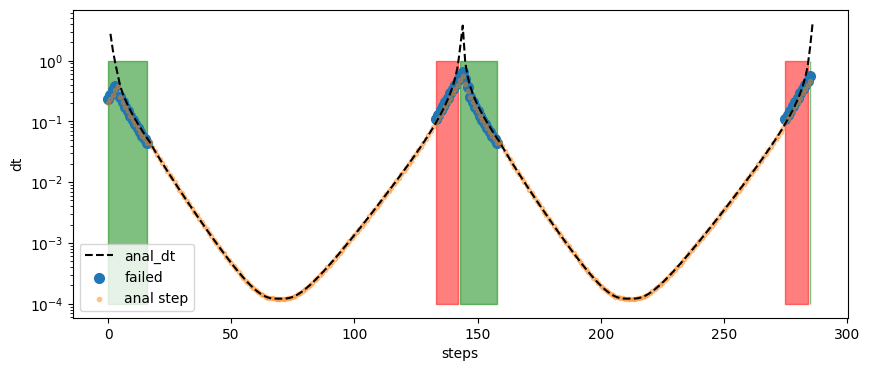

In [235]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("steps")
ax.set_ylabel("dt")
ax.set_yscale("log")
#ax.plot(mindt)
ax.plot(np.arange(len(dts))+1,dts,label="anal_dt",ls="--",c="black")
ax.fill_between(np.arange(len(d_dts)), 1e-4, 1, where=(d_dts+1) < 0.85,  color='green', alpha=0.5)
ax.fill_between(np.arange(len(d_dts)), 1e-4, 1, where=(d_dts+1) > 1./0.85,  color='red', alpha=0.5)

ax.scatter(np.arange(len(_failed)),np.array(_failed),label="failed",s=49)
#ax.scatter(np.arange(len(mindt)),mindt,label="n-body",alpha=0.4)
ax.scatter(np.arange(len(_dtaus)),np.array(_dtaus),label="anal step",s=9,alpha=0.4)
ax.legend()


In [126]:
Es = np.linspace(0.,np.pi*2.,1000)
dts = np.zeros(len(Es))
d_dts = np.zeros(len(Es))
dd_dts = np.zeros(len(Es))
for i in range(len(Es)):
    d_dts[i] = (d_anal_dt_f(_e, Es[i], _epsilon))
    dd_dts[i] = (dd_anal_dt_f(_e, Es[i], _epsilon))
    dts[i] = anal_dt_f(_e, Es[i], _epsilon)

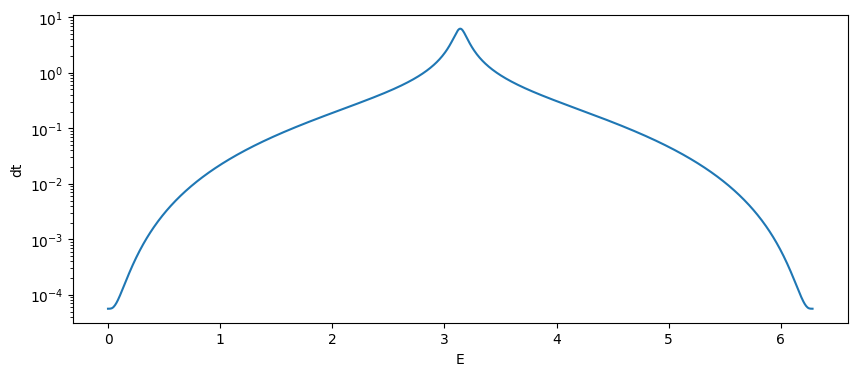

In [130]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("E")
ax.set_ylabel("dt")
ax.set_yscale("log")
#ax.set_ylim([1e-2,1e2])
ax.plot(Es, dts)

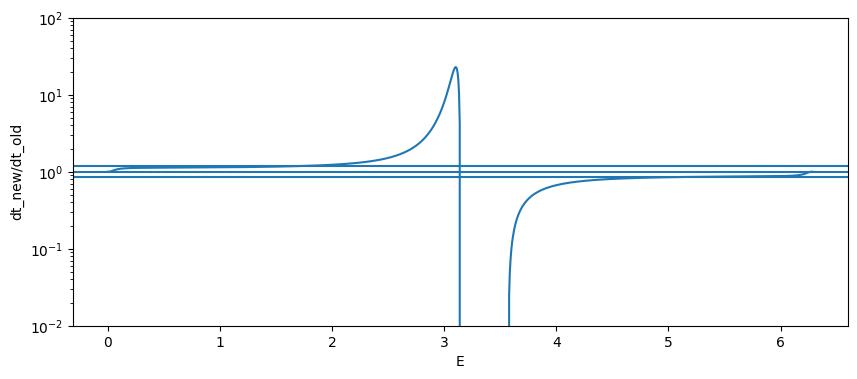

In [127]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("E")
ax.set_ylabel("dt_new/dt_old")
ax.set_yscale("log")
ax.axhline(0.85)
ax.axhline(1)
ax.axhline(1./0.85)

ax.set_ylim([1e-2,1e2])
ax.plot(Es, (d_dts)+1)
#ax.plot(Es, dd_dts)

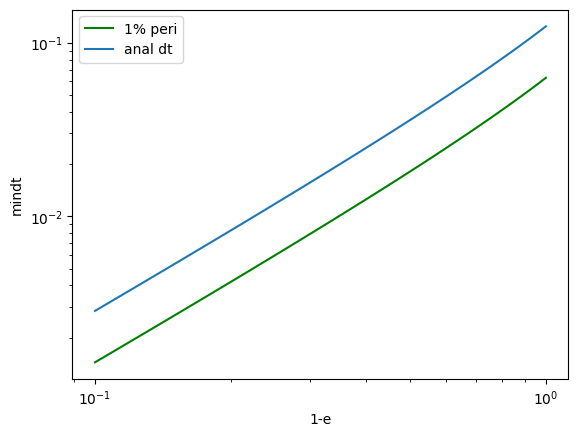

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel("1-e")
ax.set_ylabel("mindt")
ax.set_xscale("log")
ax.set_yscale("log")
es = 1.-np.logspace(-1,0,100)

anal_dt = np.zeros(len(es))

for i in range(len(es)):
    Es = np.linspace(0, np.pi*2.,10000)
    _a = np.zeros(len(Es))
    _j = np.zeros(len(Es))
    for k in range(len(Es)):
        _a[k] = np.abs(a(es[i], Es[k]))
        _j[k] = np.abs(j(es[i], Es[k]))
    epsilon = 1e-9
    b0 = _j 
    errork = _j/_a
    _anal_dt = 1./errork*2.4*np.power(1e-9,1./7.)
    anal_dt[i] = np.min(_anal_dt)


ax.plot(1.-es,1e-2*2*np.pi*(1-es)**2/np.sqrt(1-es**2),label="1% peri",color="green",zorder=4)
ax.plot(1.-es,anal_dt,label="anal dt")


ax.legend()